In [33]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt
import seaborn as sns
import math

In [7]:
train_df = pd.read_csv('data/processed/train_FD001_processed.csv')
test_df = pd.read_csv('data/processed/test_FD001_processed.csv')

In [8]:
np.random.seed(42)
all_engine_ids = train_df['engine'].unique()
np.random.shuffle(all_engine_ids)
split_percentage = 0.8
split_point = int(len(all_engine_ids) * split_percentage)

train_subset_ids = all_engine_ids[:split_point]
validation_ids = all_engine_ids[split_point:]

In [9]:
train_subset_df = train_df[train_df['engine'].isin(train_subset_ids)]
val_subset_df = train_df[train_df['engine'].isin(validation_ids)]

In [10]:
print(f"Original training engines: {len(all_engine_ids)}")
print(f"New training subset engines: {len(train_subset_ids)}")
print(f"Validation engines: {len(validation_ids)}")

Original training engines: 100
New training subset engines: 80
Validation engines: 20


In [11]:
def create_sliding_windows(df, lookback=30):
    # no comments, you can figure it out 👺
    X, y = [], []

    for engine_id in df["engine"].unique():
        engine_data = df[df["engine"] == engine_id].reset_index(drop=True)

        for i in range(len(engine_data) - lookback + 1):
            window = engine_data.iloc[i:i + lookback]
            X.append(window.drop(columns=["engine", "cycle", "RUL"]).values.flatten())
            y.append(window["RUL"].iloc[-1])
    return np.array(X), np.array(y)

In [12]:
LOOKBACK = 30
X_train, y_train = create_sliding_windows(train_subset_df, lookback=LOOKBACK)

In [13]:
def get_last_window_per_engine(df, lookback=30):
    X_test, y_test = [], []

    for engine_id in df["engine"].unique():
        engine_data = df[df["engine"] == engine_id].reset_index(drop=True)

        if len(engine_data) >= lookback:
            window = engine_data.iloc[-lookback:]
            X_test.append(window.drop(columns=["engine", "cycle", "RUL"]).values.flatten())
            y_test.append(window["RUL"].iloc[-1])
        else:
            continue

    return np.array(X_test), np.array(y_test)

In [14]:
X_test, y_test = get_last_window_per_engine(test_df, lookback=LOOKBACK)
X_val, y_val = get_last_window_per_engine(val_subset_df, lookback=LOOKBACK)

In [15]:
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Validation Set Performance

In [16]:
y_pred_val = model.predict(X_val)

In [21]:
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("--- Validation Set Performance ---")
print(f"Validation MAE: {mae_val:.2f}")
print(f"Validation RMSE: {rmse_val:.2f}\n")

print("--- Detailed Validation Predictions ---")
# true RUL is 0 since we are predicting the last cycle
for i, (true, pred) in enumerate(zip(y_val, y_pred_val)):
    print(f"Engine {i+1:03d} => True RUL = {true}, Predicted = {pred:.1f}")

--- Validation Set Performance ---
Validation MAE: 3.43
Validation RMSE: 3.49

--- Detailed Validation Predictions ---
Engine 001 => True RUL = 0.0, Predicted = 2.2
Engine 002 => True RUL = 0.0, Predicted = 3.5
Engine 003 => True RUL = 0.0, Predicted = 3.4
Engine 004 => True RUL = 0.0, Predicted = 3.8
Engine 005 => True RUL = 0.0, Predicted = 3.2
Engine 006 => True RUL = 0.0, Predicted = 3.3
Engine 007 => True RUL = 0.0, Predicted = 3.9
Engine 008 => True RUL = 0.0, Predicted = 3.4
Engine 009 => True RUL = 0.0, Predicted = 3.2
Engine 010 => True RUL = 0.0, Predicted = 4.9
Engine 011 => True RUL = 0.0, Predicted = 4.4
Engine 012 => True RUL = 0.0, Predicted = 3.0
Engine 013 => True RUL = 0.0, Predicted = 2.9
Engine 014 => True RUL = 0.0, Predicted = 3.5
Engine 015 => True RUL = 0.0, Predicted = 3.1
Engine 016 => True RUL = 0.0, Predicted = 2.9
Engine 017 => True RUL = 0.0, Predicted = 3.9
Engine 018 => True RUL = 0.0, Predicted = 4.4
Engine 019 => True RUL = 0.0, Predicted = 2.4
Engine 

### Test Set Performance

In [18]:
y_pred_test = model.predict(X_test)

In [19]:
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [20]:
print("--- Test Set Performance ---")
print(f"Test MAE: {mae_test:.2f}")
print(f"Test RMSE: {rmse_test:.2f}\n")

print("--- Detailed Test Predictions ---")
for i, (true, pred) in enumerate(zip(y_test, y_pred_test)):
    print(f"Engine {i+1:03d} => True RUL = {true}, Predicted = {pred:.1f}")

--- Test Set Performance ---
Test MAE: 19.02
Test RMSE: 25.43

--- Detailed Test Predictions ---
Engine 001 => True RUL = 112, Predicted = 150.5
Engine 002 => True RUL = 98, Predicted = 130.7
Engine 003 => True RUL = 69, Predicted = 64.0
Engine 004 => True RUL = 82, Predicted = 103.6
Engine 005 => True RUL = 91, Predicted = 119.4
Engine 006 => True RUL = 93, Predicted = 128.3
Engine 007 => True RUL = 91, Predicted = 125.8
Engine 008 => True RUL = 95, Predicted = 116.0
Engine 009 => True RUL = 111, Predicted = 137.7
Engine 010 => True RUL = 96, Predicted = 119.4
Engine 011 => True RUL = 97, Predicted = 88.3
Engine 012 => True RUL = 124, Predicted = 103.0
Engine 013 => True RUL = 95, Predicted = 95.4
Engine 014 => True RUL = 107, Predicted = 118.5
Engine 015 => True RUL = 83, Predicted = 145.1
Engine 016 => True RUL = 84, Predicted = 128.5
Engine 017 => True RUL = 50, Predicted = 58.6
Engine 018 => True RUL = 28, Predicted = 82.6
Engine 019 => True RUL = 87, Predicted = 131.4
Engine 020 

#### Visualisations

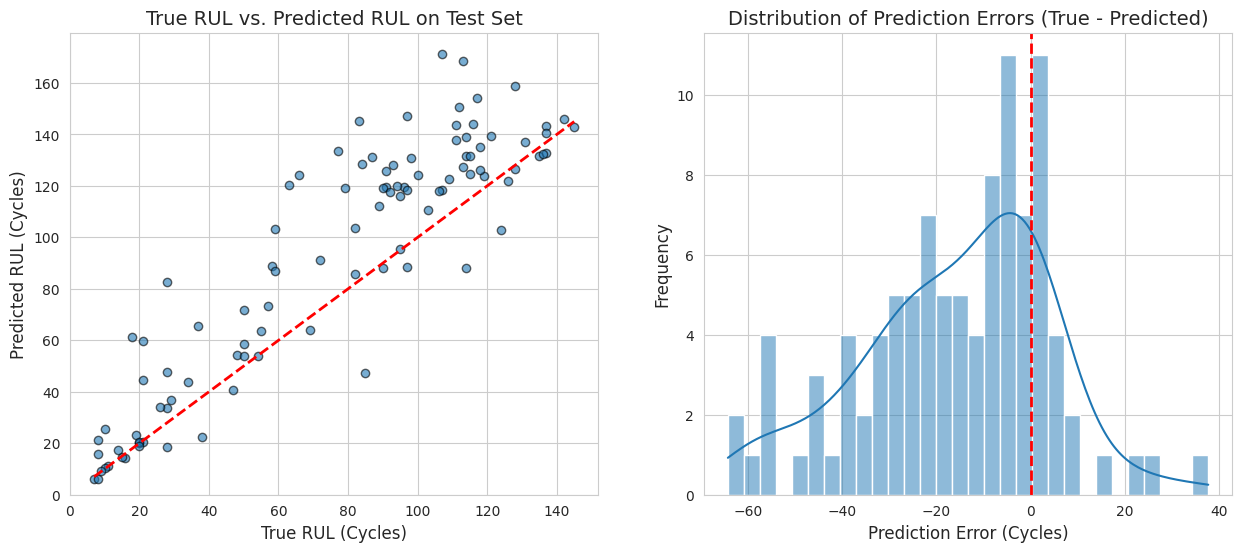

In [32]:
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.title('True RUL vs. Predicted RUL on Test Set', fontsize=14)
plt.xlabel('True RUL (Cycles)', fontsize=12)
plt.ylabel('Predicted RUL (Cycles)', fontsize=12)
plt.xlim(0)
plt.ylim(0)
plt.grid(True)

errors = y_test - y_pred_test
plt.subplot(1, 2, 2)
sns.histplot(errors, bins=30, kde=True)
plt.title('Distribution of Prediction Errors (True - Predicted)', fontsize=14)
plt.xlabel('Prediction Error (Cycles)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', lw=2)
plt.grid(True)

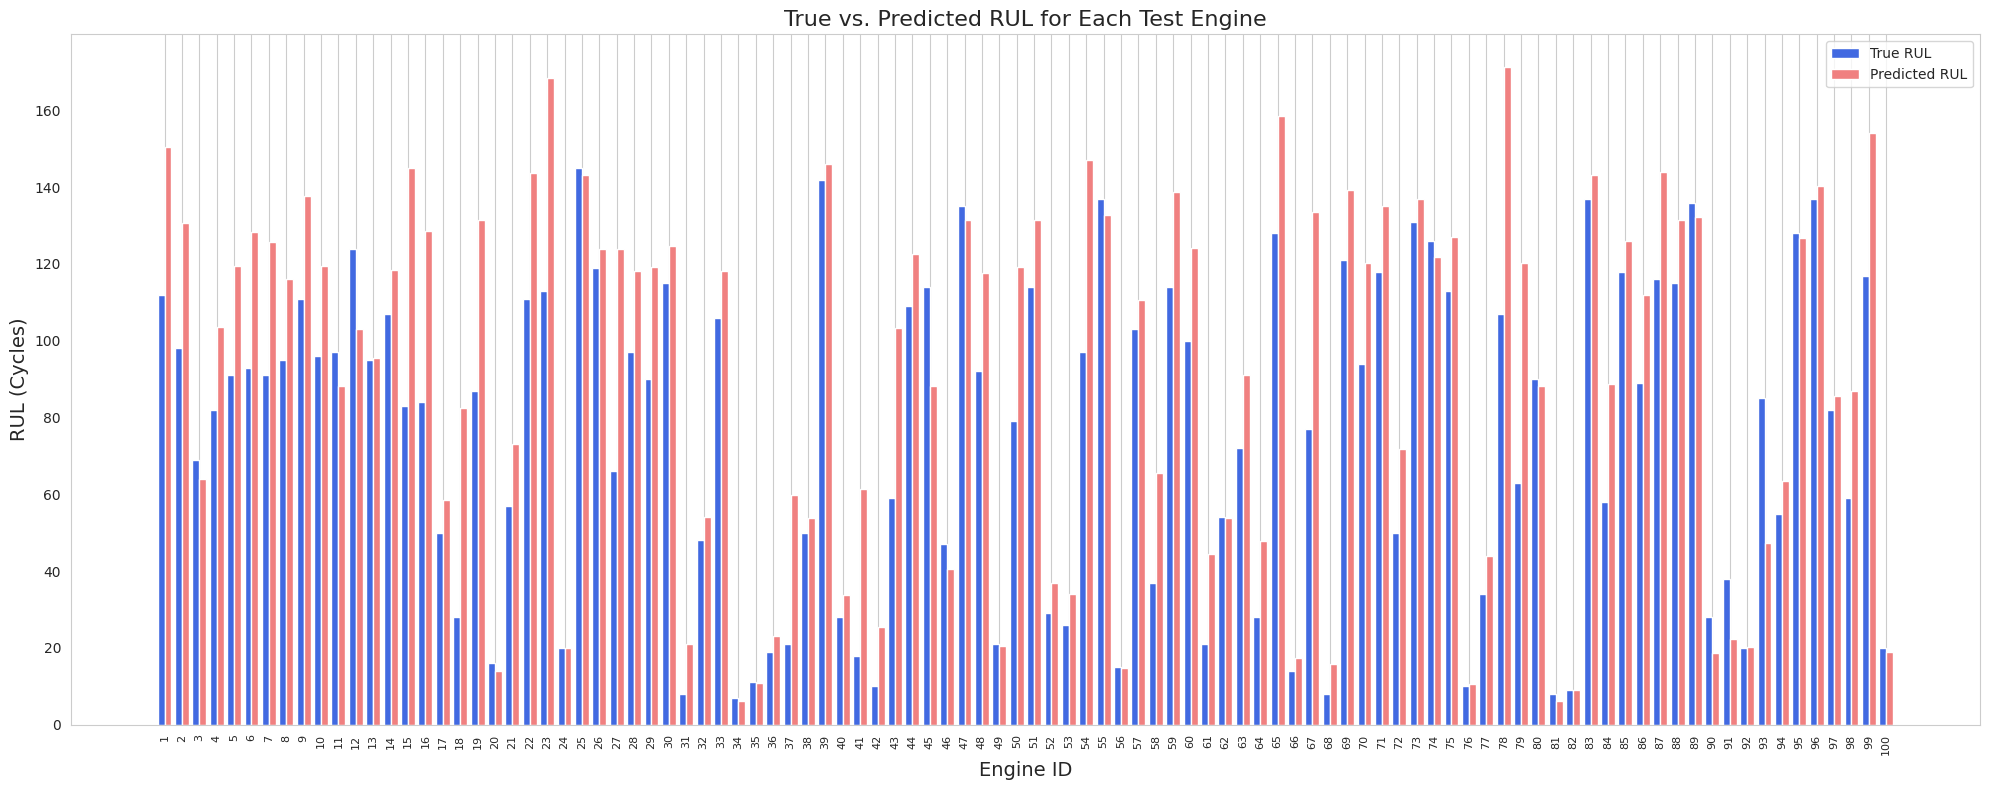

In [28]:
plt.figure(figsize=(20, 8))
engine_indices = np.arange(len(y_test)) + 1
bar_width = 0.4

plt.bar(engine_indices - bar_width/2, y_test, width=bar_width, label='True RUL', color='royalblue', align='center')
plt.bar(engine_indices + bar_width/2, y_pred_test, width=bar_width, label='Predicted RUL', color='lightcoral', align='center')

plt.title('True vs. Predicted RUL for Each Test Engine', fontsize=16)
plt.xlabel('Engine ID', fontsize=14)
plt.ylabel('RUL (Cycles)', fontsize=14)
plt.xticks(engine_indices, rotation=90, fontsize=8)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()